**Context**

Webportals like Bhuvan get vast amount of feedback from the users. To go through all the feedback's can be a tedious job. You have to categorize opinions expressed in feedback forums. This can be utilized for feedback management system. We Classification of individual comments/reviews.and we also determining overall rating based on individual comments/reviews. So that company can get a complete idea on feedback's provided by customers and can take care on those particular fields. This makes more loyal Customers to the company, increase in business , fame ,brand value ,profits.


**Content**

This file has reviewer ID , User ID, Reviewer Name, Reviewer text, helpful, Summary(obtained from Reviewer text),Overall Rating on a scale 5, Review time
Description of columns in the file:

reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B

asin - ID of the product, e.g. 0000013714

reviewerName - name of the reviewer

helpful - helpfulness rating of the review, e.g. 2/3

reviewText - text of the review

overall - rating of the product

summary - summary of the review

unixReviewTime - time of the review (unix time)

reviewTime - time of the review (raw)


**Task**
You have to perform Sentimental Analysis for this data. Help the organization to understand better about their customer feedback's So that they can concentrate on those issues customer's are facing. Build the model which has highest accuracy in classifying the feedback as positive,Negative and neutral.

Task :1
You have to categorize opinions expressed in feedback forums

Task :2
You have to classify individual comments/reviews and you have to determine overall rating based on individual
comments/reviews.

**Inspiration**
This is the Problem Statement given by ISRO to classify the customer comments. This would be helpful for the organization to understand Customer feedbacks.

##### **Importing necessary libraries**

In [1994]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import json
from sklearn import metrics
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk  
from sklearn import tree
nltk.download('stopwords')  
from nltk.corpus import stopwords  
from sklearn.neighbors import KNeighborsClassifier
import warnings
import pickle
import joblib
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1995]:
#Reading file
reviews = pd.read_csv('C:\\Users\\Asus\\Desktop\\AmazonAnalysis\\Musical_instruments_reviews.csv')
reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [1996]:
#Data info
print(reviews.shape)
print()
print(reviews.info())
print()
print(reviews.describe())
print()

(10261, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
reviewerID        10261 non-null object
asin              10261 non-null object
reviewerName      10234 non-null object
helpful           10261 non-null object
reviewText        10254 non-null object
overall           10261 non-null float64
summary           10261 non-null object
unixReviewTime    10261 non-null int64
reviewTime        10261 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None

            overall  unixReviewTime
count  10261.000000    1.026100e+04
mean       4.488744    1.360606e+09
std        0.894642    3.779735e+07
min        1.000000    1.095466e+09
25%        4.000000    1.343434e+09
50%        5.000000    1.368490e+09
75%        5.000000    1.388966e+09
max        5.000000    1.405987e+09



#### **CHECKING NaN values**

In [1997]:
reviews.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [1998]:
#Dropping NaN values, since we have more than 10k of observations
reviews.dropna(inplace=True)

#### **DATA AUGMENTATION**

In [1999]:
class Sentiment:
    POSITIVE = "POSITIVE"
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"

#Creating Columns for the year, month and day
def get_year(reviewTime):
    return reviewTime.split(",")[1].strip(" ")

#Function to create 
def get_day(reviewTime):
    return reviewTime.split(" ")[1].strip(",")

#Sentiment Score   
def get_sentiment(score):
    if score <= 2:
        return 'NEGATIVE'
    elif score == 3:
        return 'NEUTRAL'
    else: 
        return 'POSITIVE'
    
def text_clean(text):
    text = re.sub(r'@[A-Za-z0-9]','',text)#Removes @mentions
    text = re.sub(r'#','',text)#Removing the Hashtag
    text = re.sub(r'RT[\s]','',text)#Removing RT
    text = re.sub(r'_','',text)#Removing RT
    return text

def balanced_sentiment(score):
    if score > 3:
        return 'POSITIVE'
    else:
        return 'NEGATIVE'

In [2000]:
#Creating Three columns spliiting by year, month and day
reviews['count'] = 1
reviews['year'] = reviews.reviewTime.apply(get_year)
reviews['month'] =  reviews['reviewTime'].str[:2]
reviews['day'] = reviews.reviewTime.apply(get_day)
reviews['Sentiment'] = reviews.overall.apply(get_sentiment)

#Converting Column data type from object to integer
reviews['year'] = reviews['year'].astype('int64')
reviews['month'] = reviews['month'].astype('int64')
reviews['day'] = reviews['day'].astype('int64')

#### **DATA VISUALIZATION AND ANALYSIS**

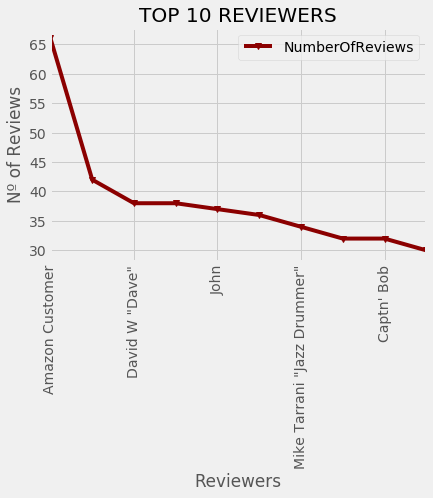

In [2001]:
#Top 10 reviewers
top_ten = reviews['reviewerName'].value_counts()
top_ten = top_ten.head(10)
top_ten = pd.DataFrame(top_ten)
top_ten.columns = ['NumberOfReviews']

top_ten.plot(color='darkred',marker='v',linestyle='-')
plt.xticks(rotation=90)
plt.title('TOP 10 REVIEWERS')
plt.xlabel('Reviewers')
plt.ylabel('Nº of Reviews')
plt.show()

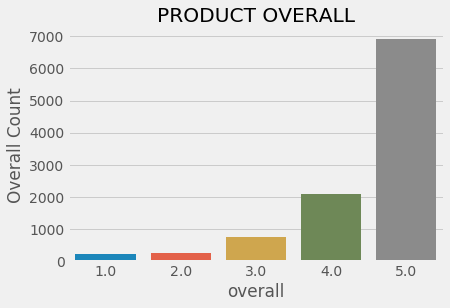

In [2002]:
#Product Valuation
sns.countplot(data=reviews, x='overall')
plt.ylabel('Overall Count')
plt.title('PRODUCT OVERALL')
plt.show()

<Figure size 1008x720 with 0 Axes>

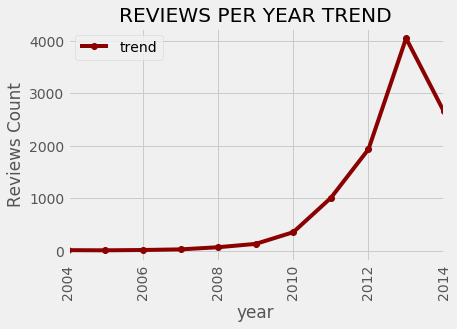

In [2003]:
#Grouping By  year
year_review = reviews.groupby(by='year').sum()
year_review = year_review.drop(columns=['month','day','overall','unixReviewTime'])
year_review.columns = ['trend']
plt.figure(figsize=(14,10))
year_review.plot(color='darkred',linestyle='-',marker='o')
plt.xticks(rotation=90)
plt.ylabel('Reviews Count')
plt.title('REVIEWS PER YEAR TREND')
plt.show()

<Figure size 1008x720 with 0 Axes>

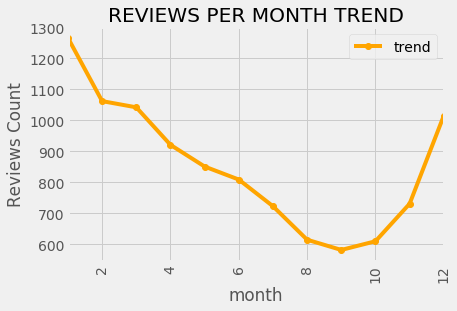

In [2004]:
#Grouping By  Month
month_review = reviews.groupby(by='month').sum()
month_review = month_review.drop(columns=['year','day','overall','unixReviewTime'])
month_review.columns = ['trend']
plt.figure(figsize=(14,10))
month_review.plot(color='orange',linestyle='-',marker='o')
plt.xticks(rotation=90)
plt.ylabel('Reviews Count')
plt.title('REVIEWS PER MONTH TREND')
plt.show()

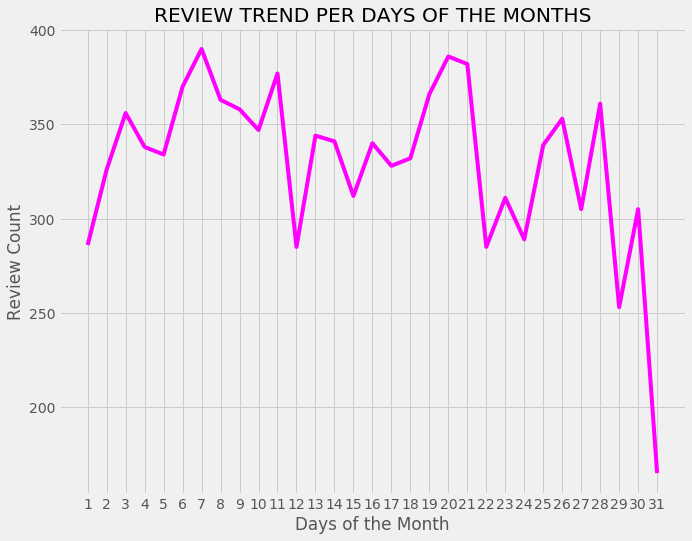

In [2005]:
#Trend by day of the month
day = reviews
day = day.sort_values(by=['day'],ascending=True)
day =  day.groupby(by=['day']).sum()
day = day.drop(columns=['overall', 'unixReviewTime','year','month'])
day.columns = ['trend']
#Line plot
plt.figure(figsize=(10,8))
sns.lineplot(data=day, x=day.index, y='trend',color='magenta')
plt.xticks(day.index)
plt.ylabel('Review Count')
plt.xlabel('Days of the Month')
plt.title('REVIEW TREND PER DAYS OF THE MONTHS')
plt.show()

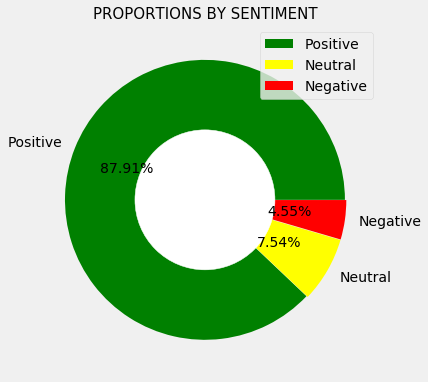

In [2006]:
#Reviews Sentiment
size_complete = reviews['Sentiment'].value_counts()
colors_complete = ['green', 'yellow','red']
labels_complete = "Positive", "Neutral","Negative"
explode = [0, 0.01,0.01]

#(0,0) is to create the circle and 0.5 for the width of the circle, white is for the center of the circle
my_circle_complete = plt.Circle((0, 0), 0.5, color = 'white')

plt.figure(figsize=(8,6))
plt.pie(size_complete, colors = colors_complete, labels = labels_complete, shadow = False, explode = explode, autopct = '%.2f%%')
plt.title('PROPORTIONS BY SENTIMENT', fontsize = 15)
p = plt.gcf()
p.gca().add_artist(my_circle_complete)
plt.legend()
plt.show()


### **CREATING MODEL**

In [2007]:
#Creating the inputa Array of values and the target
X = reviews['reviewText']
y = reviews['Sentiment']
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [2008]:
#Let's clean the text of the reviews
X['reviewText'] = X['reviewText'].apply(text_clean)

In [2009]:
#TF-IDF
tfidf = TfidfVectorizer(
    stop_words = 'english',
    max_features=20
)
tfidf.fit(X.reviewText)
text = tfidf.transform(X.reviewText)

In [2010]:
#Data Split
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(text, y, test_size=0.25, random_state=0)
 
 #RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
text_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
text_classifier.fit(X_train, y_train)
 
 #Creating Model
predictions = text_classifier.predict(X_test)
 
#Model Accuracy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
 
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(accuracy_score(y_test, predictions))

[[   0    0  116]
 [   3    3  182]
 [   8   14 2231]]
              precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00       116
     NEUTRAL       0.18      0.02      0.03       188
    POSITIVE       0.88      0.99      0.93      2253

    accuracy                           0.87      2557
   macro avg       0.35      0.34      0.32      2557
weighted avg       0.79      0.87      0.82      2557

0.8736800938599921


In [2011]:
#Model check
test_set = ["very good",'this guitar rocks',"I didn't expect this cable to be so thin",'bad bad bad bad no way']
new_test = tfidf.transform(test_set)

text_classifier.predict(new_test)

array(['POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE'], dtype=object)

Our Model is very good to predict positive feedbacks, but is very bad to predict neutra or negative comments, so since we don´t have more data, lets undersample the positive examples

#### **Undersampled Model** 

Reducing abundant class 

In [2012]:
#Create a new dataset with balanced data
undersample = reviews.sort_values(by=['Sentiment'],ascending=True)
#Create a dataframe with only positive sentiment
positive = reviews[reviews['Sentiment']=='POSITIVE']
#Extracting only 800 rows to balance POSITIVE CLASS
positive = positive.iloc[0:700,]
#Drop the positive sentiment from the undersample dataframe
undersample = undersample[undersample['Sentiment']!= 'POSITIVE']
#Concat dataframe
undersample = pd.concat([undersample, positive])
#Shuffle Rows to randomize
undersample = undersample.sample(frac=1)

In [2013]:
#Data Prep
X_undersample = undersample['reviewText']
y_undersample = undersample['Sentiment']
X_undersample = pd.DataFrame(X_undersample)
y_undersample = pd.DataFrame(y_undersample)

In [2014]:
#Let's clean the text of the reviews
X_undersample['reviewText'] = X_undersample['reviewText'].apply(text_clean)

In [2015]:
#Fitting TF-IDF
tfidf_undersample = TfidfVectorizer(
    stop_words = 'english',
    max_features=20
)
tfidf_undersample.fit(X_undersample.reviewText)
corpus = tfidf_undersample.transform(X_undersample.reviewText)

In [2016]:
#Data Split
X_train, X_test, y_train, y_test = train_test_split(corpus, y_undersample, test_size=0.3, random_state=0)
 
 #RandomForestClassifier
text_classifier = RandomForestClassifier(n_estimators=10, random_state=0)  
text_classifier.fit(X_train, y_train)
 
 #Creating Model
predictions = text_classifier.predict(X_test)
 
#Model Accuracy 
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(accuracy_score(y_test, predictions))

[[ 43  47  39]
 [ 60 103  68]
 [ 58  76  87]]
              precision    recall  f1-score   support

    NEGATIVE       0.27      0.33      0.30       129
     NEUTRAL       0.46      0.45      0.45       231
    POSITIVE       0.45      0.39      0.42       221

    accuracy                           0.40       581
   macro avg       0.39      0.39      0.39       581
weighted avg       0.41      0.40      0.40       581

0.4010327022375215


In [2017]:
#Decision Tree
tree_classifier = tree.DecisionTreeClassifier()
tree_text_classifier = tree_classifier.fit(X_train,y_train)

tree_predictions = tree_text_classifier.predict(X_test)

#Model Accuracy 
print(confusion_matrix(y_test,tree_predictions))  
print(classification_report(y_test,tree_predictions))  
print(accuracy_score(y_test, tree_predictions))

[[45 43 41]
 [71 76 84]
 [66 66 89]]
              precision    recall  f1-score   support

    NEGATIVE       0.25      0.35      0.29       129
     NEUTRAL       0.41      0.33      0.37       231
    POSITIVE       0.42      0.40      0.41       221

    accuracy                           0.36       581
   macro avg       0.36      0.36      0.35       581
weighted avg       0.38      0.36      0.37       581

0.3614457831325301


In [2018]:
model_test = ['bad guitar','no words','very good guitar','the suction cup does not work']
model_test = tfidf_undersample.transform(model_test)

tree_text_classifier.predict(model_test)

array(['NEGATIVE', 'NEGATIVE', 'NEUTRAL', 'NEUTRAL'], dtype=object)

In [2019]:
model_test = ['bad guitar','no words','very good guitar','the suction cup does not work']
model_test = tfidf_undersample.transform(model_test)

print(text_classifier.predict(model_test))

['POSITIVE' 'NEGATIVE' 'NEUTRAL' 'NEUTRAL']


After reducing the number of positive observations to 800, the model has become a little more balanced, however in this case it has a fairly low effectiveness for the three types of feelings, and predicts mostly neutral and positive and very few negative cases. so another model will be tried.

### **Negative and Positive sentiments**

People who rate something with three stars are more likely to not be happy with the stuff bought. So let´s include this people, that was considered as neutral, now considered as negative feedbacks.

In [2020]:
#Create a dataframe based on the original one
balanced = reviews
#Drop Sentiment Column to create a new one with onle positive and negative columns
balanced = balanced.drop(columns=['Sentiment'])
#Applying function
balanced['Sentiment'] = balanced['overall'].apply(balanced_sentiment)

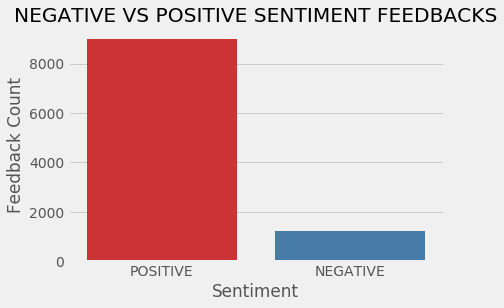

In [2021]:
#Let´s visualize the Sentiments now
sns.countplot(data=balanced, x='Sentiment',palette='Set1')
plt.title('NEGATIVE VS POSITIVE SENTIMENT FEEDBACKS')
plt.ylabel('Feedback Count')
plt.show()

Around 1.2k are negative feedbacks, so let´s undersample again the positive feedbacks, since we don´t have
any additional data

In [2022]:
#Creating a dataframe with only  positive feedbacks
balanced_positive = balanced[balanced['Sentiment']=='POSITIVE']
#Let`s extract 1300 observations
balanced_positive = balanced_positive.iloc[0:1300,]
#Let´s drop negative Sentiments from the original dataframe
balanced = balanced[balanced['Sentiment']!='POSITIVE']
#Let's concat both dataset and compare target variable
balanced = pd.concat([balanced, balanced_positive])

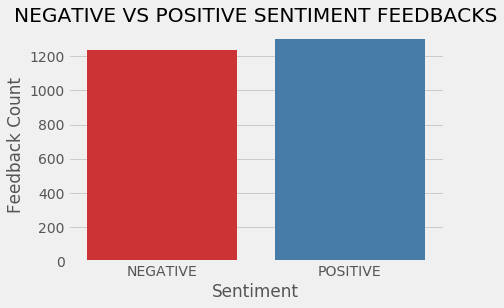

In [2023]:
sns.countplot(data=balanced, x='Sentiment',palette='Set1')
plt.title('NEGATIVE VS POSITIVE SENTIMENT FEEDBACKS')
plt.ylabel('Feedback Count')
plt.show()

In [2024]:
#Data Prep
X_balanced = balanced['reviewText']
y_balanced = balanced['Sentiment']
X_balanced = pd.DataFrame(X_balanced)
y_balanced = pd.DataFrame(y_balanced)

In [2025]:
#Let's clean the text of the reviews
X_balanced['reviewText'] = X_balanced['reviewText'].apply(text_clean)

In [2026]:
#Fitting TF-IDF
tfidf_balance = TfidfVectorizer(
    stop_words = 'english',
    max_features=20
)
tfidf_balance.fit(X_balanced.reviewText)
texts = tfidf_balance.transform(X_balanced.reviewText)

In [2027]:
#Data Split
X_train, X_test, y_train, y_test = train_test_split(texts, y_balanced, test_size=0.3, random_state=0)
 
 #RandomForestClassifier
balanced_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
balanced_classifier.fit(X_train, y_train)
 
 #Creating Model
predictions_balanced = balanced_classifier.predict(X_test)
 
#Model Accuracy
 
print(confusion_matrix(y_test,predictions_balanced))  
print(classification_report(y_test,predictions_balanced))  
print(accuracy_score(y_test, predictions_balanced))

[[204 172]
 [143 242]]
              precision    recall  f1-score   support

    NEGATIVE       0.59      0.54      0.56       376
    POSITIVE       0.58      0.63      0.61       385

    accuracy                           0.59       761
   macro avg       0.59      0.59      0.59       761
weighted avg       0.59      0.59      0.59       761

0.5860709592641261


In [2028]:
#Model Check
model_test = ['nice guitar','bad','very good guitar','not fine']
model_test = tfidf_balance.transform(model_test)

print(balanced_classifier.predict(model_test))

['POSITIVE' 'NEGATIVE' 'POSITIVE' 'NEGATIVE']


In [2029]:
#K-nearest Neighbor classifier, let´s use 2 neighbors since we only have to classes
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

knn_prediction = knn.predict(X_test)
print(confusion_matrix(y_test,knn_prediction))  
print(classification_report(y_test,knn_prediction))  
print(accuracy_score(y_test, knn_prediction))

[[217 159]
 [164 221]]
              precision    recall  f1-score   support

    NEGATIVE       0.57      0.58      0.57       376
    POSITIVE       0.58      0.57      0.58       385

    accuracy                           0.58       761
   macro avg       0.58      0.58      0.58       761
weighted avg       0.58      0.58      0.58       761

0.5755584756898817


In [2030]:
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 20)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 20
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

print(scores)

[0.533508541392904, 0.5413929040735874, 0.5532194480946123, 0.5505913272010512, 0.568988173455979, 0.5663600525624178, 0.5650459921156373, 0.5755584756898817, 0.5663600525624178, 0.5650459921156373, 0.5676741130091985, 0.5676741130091985, 0.5716162943495401, 0.5663600525624178, 0.5637319316688568, 0.5611038107752957, 0.5624178712220762, 0.5676741130091985, 0.5505913272010512]


Text(0, 0.5, 'Testing Accuracy')

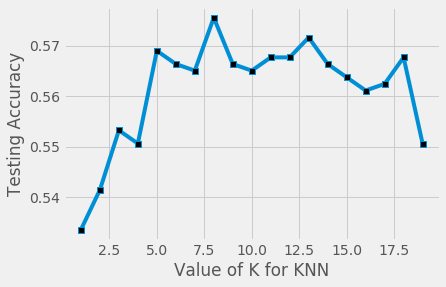

In [2031]:
plt.plot(k_range, scores,marker='s',markerfacecolor='black')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [2032]:
#Model Check
model_test = ['nice guitar, and excellent buy','bad cable, not plugged in','very good guitar','not fine, but it works']
model_test = tfidf_balance.transform(model_test)

print(knn.predict(model_test))

['POSITIVE' 'NEGATIVE' 'NEGATIVE' 'NEGATIVE']


The first model have the best accuracy, but is very bad to predict classes differente from positive. The last model is the most balanced one based on the f1-score, so is the best one of all. However the fact that theres no more data to train our model (data for neutral or negative feedback) is a little bit hard to improve. However there are ways to improve the model  a little bit, but more data is needed.

In [2033]:
#Saving Model
joblib.dump(balanced_classifier,'amazon_sentiment_recommender.joblib')


['amazon_sentiment_recommender.joblib']